# Projet Explainable Artificial Intelligence (XAI)
Thomas Deltort, Charlotte Blondel, Ema Cadaux, Paul Londres, Gaétan Meis.

This is the last part of the course project.
The aim of this project is to explain the decisions made by a reinforcement learning agent using different interpretability methods. In this Notebook, the game used is fruitbot from the **procgen** suite and the methods presented are: **Lime**, **Vanilla gradient**, **Smooth grad** and **Grad-CAM**.

Fruitbot (our environnement) is "a scrolling game where the player controls a robot that must navigate between
gaps in walls and collect fruit along the way. The player receives a positive
reward for collecting a piece of fruit, and a larger negative reward for  mistakenly collecting a non-fruit object.

On expectation, half of the spawned objects are
fruit (positive reward) and half are non-fruit (negative reward). The player
receives a large reward if they reach the end of the level. Occasionally the
player must use a key to unlock gates which block the way.
Procedural generation controls the level layout by sequentially generating
barriers with randomly-sized gaps. It also controls the quantity and configuration of fruit and non-fruit objects, as well as the placement of gates."

*COBBE, Karl, HESSE, Chris, HILTON, Jacob, et al. Leveraging procedural generation to benchmark reinforcement learning. In : International conference on machine learning. PMLR, 2020. p. 2048-2056.*

Installation de procgen et configuration de l'agent :

In [1]:
!pip install procgen > /dev/null 2>&1

In [2]:
!wget --no-check-certificate "https://drive.google.com/uc?id=1FnLCCYnvhuT5FBpzH3vjeesztZGhtgSx" -O "agent_weights.pth"
!wget --no-check-certificate "https://raw.githubusercontent.com/DavidBert/AIF2024/main/xai/project/agent.py"
!wget --no-check-certificate "https://raw.githubusercontent.com/DavidBert/AIF2024/main/xai/project/procgen_wrappers.py"

--2024-02-02 09:06:02--  https://drive.google.com/uc?id=1FnLCCYnvhuT5FBpzH3vjeesztZGhtgSx
Resolving drive.google.com (drive.google.com)... 142.251.2.139, 142.251.2.138, 142.251.2.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1FnLCCYnvhuT5FBpzH3vjeesztZGhtgSx [following]
--2024-02-02 09:06:02--  https://drive.usercontent.google.com/download?id=1FnLCCYnvhuT5FBpzH3vjeesztZGhtgSx
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2522817 (2.4M) [application/octet-stream]
Saving to: ‘agent_weights.pth’

agent_weights.pth   100%[===================>]   2.41M  15.3MB/s    in 0.2s    

2024-02-02 09:06:04 (15.3 MB/s) 

In [3]:
import torch
from procgen import ProcgenEnv
from agent import Agent
from procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

agent = Agent().cuda()
agent.load_state_dict(torch.load('agent_weights.pth'))

env = ProcgenEnv(
        num_envs=1,
        env_name="fruitbot",
        start_level=0,
        num_levels=100,
        distribution_mode='easy',
    )

env = VecExtractDictObs(env, "rgb")
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

In [4]:
import torch
from procgen import ProcgenEnv
from procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

env = ProcgenEnv(
        num_envs=1,
        env_name="fruitbot",
        start_level=0,
        num_levels=100,
        distribution_mode='easy',
    )

env = VecExtractDictObs(env, "rgb")
env = TransposeFrame(env)
env = ScaledFloatFrame(env)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(-0.5, 63.5, 63.5, -0.5)

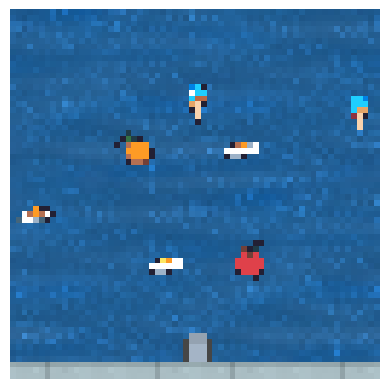

In [5]:
import matplotlib.pyplot as plt

obs = env.reset()
plt.imshow(obs[0].transpose(1,2,0))
plt.axis('off')

On définit des fonctions qui nous serons utiles pour l'affichage des résultats sous forme de gif

In [6]:
import imageio
from IPython.display import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

def obs_to_image(obs):
  return (obs[0].transpose(1,2,0) * 255).astype(np.uint8)

def obs_to_image2(obs):
  return (obs[0] * 255).astype(np.uint8)

def display_trajectory(frames, duration = 42):
  imageio.mimwrite('./tmp.gif',
                [obs_to_image(frame) for i, frame in enumerate(frames)],
                duration=duration)
  return(Image(open('tmp.gif','rb').read(), width=500, height=500))

def display_trajectory_with_gradients(frames, gradients, duration=84):
    # Original frames gif
    frames_gif = [obs_to_image(frame) for frame in frames]
    gradient_gif = [obs_to_image(grad) for grad in gradients]
    # Combine original frames and gradients into a single gif
    combined_frames = [np.concatenate([frame, gradient], axis=1) for frame, gradient in zip(frames_gif, gradient_gif)]

    # Save the combined frames gif
    imageio.mimwrite('./combined_frames.gif', combined_frames, duration = duration)
    return Image(open('./combined_frames.gif', 'rb').read(), width=1000, height=500)


To better understand our agent's decisions, we went to find out how his reward system worked.

<figure>
<center>
<img src='https://drive.google.com/uc?export=download&id=1yd98IvDVjkXVJfSqqNB92KyEzSfYE1-Y'/>
<figcaption>Reward System</figcaption></center>
</figure>

Because there is no passive reward for actions that extend the game, the reward function is sparse and sufficient exploration is crucial towards encouraging an agent to both seek out fruit and finish the level.

Simulation of a trajectory in the game environment using the Impala trained agent and creation of an animated GIF to visualize the trajectory:

In [7]:
frames = []
obs = env.reset()

while True:
    frames.append(obs)
    obs = torch.FloatTensor(obs).to('cuda')
    action = agent(obs).argmax(1).cpu().numpy()
    obs, _, done ,_ = env.step(action)
    img = env.render()
    if done[0]:
        break

env.close()

display_trajectory(frames)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
from IPython.display import display, Image
def create_gif(images, filename, duration = 84):
    """
    Create a gif from a list of images.

    Parameters:
    - images: List of NumPy arrays representing images.
    - filename: Output file name for the gif.
    """
    # Ensure the images are in the correct format (uint8)
    #images = [(image * 255).astype(np.uint8) for image in images]
    images = [(image * 255).astype(np.uint8) for image in images]
    # Save the images to a gif file
    imageio.mimwrite(filename, images, duration = duration)
    display(Image(filename=filename, width=500, height=500))

## LIME

**LIME** *(Local Interpretable model-agnostic explanation)* is a local method: it allows us to understand why the agent made the decision it did in the specific case described. This differs from global methods, which describe the general behavior of the model and reveal the agent's main biases.

Furthermore, LIME is a model-agnostic method, as it does not require any knowledge of the model.

The aim of this method is to emulate the model's behavior with an easily interpretable model surrogate. To achieve this, the method selects instances and creates local perturbations. Then, the surrogate model is trained on the perturbed instances and their predictions extracted with the black-box model. The most influential regions of the image contribute to the model's decisions.

In [9]:
!pip install lime > /dev/null 2>&1

In [10]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/500 [00:00<?, ?it/s]

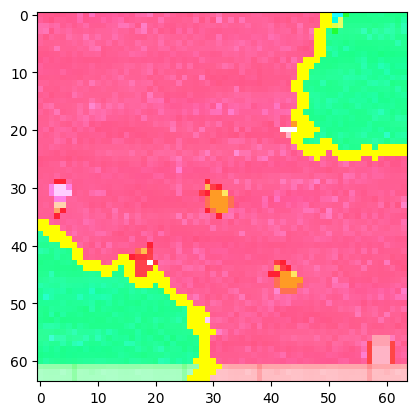

In [11]:
import cv2
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries

def obs_to_image(obs):
    # Assuming obs is a single environment state
    return (obs[0].transpose(1, 2, 0) * 255).astype(np.uint8)


# Assuming env is your ProcGen environment
np_img = env.reset()

# Convert the environment state to an image
img = obs_to_image(np_img)

def batch_predict(images):
    batch = []
    for i in images:
        # Convert the NumPy array to a PyTorch tensor
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        i = torch.tensor(i.transpose(2, 0, 1), dtype=torch.float32).to(device)
        # Add batch dimension
        i = i.unsqueeze(0)
        # Forward pass through the model
        output = agent(i)
        output = output.cpu().detach().numpy()
        batch.append(output[0])
    return batch

def compute_lime_mask(img, batch_predict):
  # Create a LimeImageExplainer
  explainer = lime_image.LimeImageExplainer()
  # Explain the instance
  explanation = explainer.explain_instance(
      img,
      batch_predict,  # Use your modified batch_predict function
      hide_color=0,
      top_labels=5,
      num_samples=500
  )

  # Get the explanation image and mask
  temp, mask = explanation.get_image_and_mask(
      explanation.top_labels[0],
      positive_only=False,
      num_features=10,
      hide_rest=False
  )

  # Mark boundaries on the explanation image
  img_boundry = mark_boundaries(temp / 255.0, mask)

  return(img_boundry)
# Display the image with boundaries
plt.imshow(compute_lime_mask(img, batch_predict))


This code uses Lime to generate an explanation of the model's predictions on an environment's image.

The plot represents this image with marked boundaries indicating influential regions.

* Regions marked in green indicate positive contributions to the model's prediction.

* Red areas highlight features that have a negative impact on the model's prediction.

* Yellow regions represent areas that have a minor influence on the model's prediction. They may contribute slightly to the prediction but are not as significant as the green regions.

This next section is computing lime mask on every frames. It has been limited to 150 in order to limit computing time, it should take 4 minutes.

In [ ]:
frames = []
lime_frames = []
obs = env.reset()
it = 0
while True:
    frames.append(obs)
    image = obs_to_image(obs)
    it += 1
    print(it)
    lime_frames.append(compute_lime_mask(image, batch_predict))
    obs = torch.FloatTensor(obs).to('cuda')
    action = agent(obs).argmax(1).cpu().numpy()
    obs, _, done ,_ = env.step(action)
    img = env.render()
    if done[0]:
        break
    if it >= 150:
      break

#env.close()

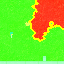

In [17]:
create_gif(lime_frames,'lime.gif')

We can see from the GIF that the fruits often belong to the yellow regions, and are therefore minorly taken into account in the model's decision. We can also see that the model concentrates most of the time on the bottom of the image to take its decisions, therefore it doesn't anticipate much. Moreover, when an obstacle is close, only the area preceding the obstacle is positevely taken into account in the decision. Zones tend to be separated by the walls. The green areas cover the agent's zone as well as the opening in the wall, suggesting that this is what our agent is going to target. But Lime is too imprecise a method to draw clear conclusions about our agent's behaviour.

## Vanilla gradients

In [14]:
def compute_vanilla_gradient(model, state):
    state = np.array(state, dtype=np.float32)

    # Ensure the model and input tensor are on the same device
    device = next(model.parameters()).device
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device, requires_grad=True)

    output = model(state_tensor)
    output.mean().backward()  # Backward pass to compute gradients

    gradients = state_tensor.grad.cpu().numpy()  # Move gradients to CPU before conversion to numpy
    return gradients

In [39]:
frames = []
gradients = []
obs = env.reset()

while True:
    frames.append(obs)
    gradients.append(compute_vanilla_gradient(agent, obs))

    obs = torch.FloatTensor(obs).to('cuda')
    action = agent(obs).argmax(1).cpu().numpy()
    obs, _, done ,_ = env.step(action)
    img = env.render()
    if done[0]:
        break

#env.close()

display_trajectory_with_gradients(frames, gradients, duration = 84)

Output hidden; open in https://colab.research.google.com to view.

Like the Lime method, the vanilla gradients shows how the model behaves and its sensitivity. It helps us understanding the model's decisions.

The greater the gradient obtained, the more important the pixel in question is in the model's decision. This method performs well, as the largest gradients are obtained for the bot, fruit and obstacles, regardless of their distance from the bot. We have the impression that the fruit is represented more in red and the obstacles in blue and green.  We deliberately left the gradients in RGB to potentially capture this kind of phenomenon.

During certain executions, we were able to observe two typical behaviours: if a non-fruit object is in the wall opening, the agent will systematically run into the wall. This is a logical behaviour, since taking a wall does not incur a penalty, unlike non-fruit objects. If a piece of fruit is just behind a wall, too close to the current position, the agent will run into the wall trying to get through.


## Smooth Grad
Explications at the end

In [18]:
def get_vanilla_grad(model, state):
    state = np.array(state, dtype=np.float32)

    # Ensure the model and input tensor are on the same device
    device = next(model.parameters()).device
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device, requires_grad=True)

    output = model(state_tensor)
    output_idx = output.argmax()
    output_max = output[0, output_idx]
    output_max.backward()

    gradients = state_tensor.grad.cpu().numpy()  # Move gradients to CPU before conversion to numpy
    #return gradients
    return np.max(gradients[0], axis=0) # si on veut du gray scale

In [19]:
import numpy as np

def compute_smooth_grad(model, img):

  stdev_spread=0.1
  n_samples=100
  stdev = stdev_spread * (img.max() - img.min())
  total_gradients = np.zeros(np.shape(img))

  for i in range(n_samples):
      noise = np.random.normal(0, stdev.item(), img.shape).astype(np.float32)
      noisy_img = img + noise
      grad= get_vanilla_grad(model, noisy_img)
      total_gradients += grad * grad #using the square of the gradients generates smoother visualizations
      total_gradients += grad
  total_gradients /= n_samples
  saliency = abs(total_gradients)
  return(saliency)


attention ça peut être long ! (de 2 à 10 minutes selon si l'agent prend un mur)

In [20]:
frames = []
smooth_gradients = []
obs = env.reset()
while True:
    frames.append(obs)
    smooth_gradients.append(compute_smooth_grad(agent, obs))

    obs = torch.FloatTensor(obs).to('cuda')
    action = agent(obs).argmax(1).cpu().numpy()
    obs, _, done ,_ = env.step(action)
    img = env.render()
    if done[0]:
      break

env.close()

display_trajectory_with_gradients(frames, smooth_gradients)

Output hidden; open in https://colab.research.google.com to view.

In [41]:
display_trajectory_with_gradients(frames, smooth_gradients, duration = 42)

Output hidden; open in https://colab.research.google.com to view.

This code computes SmoothGrad saliency maps for each frame of the trajectory. In this case, the degree of contribution (saliency) of each pixel is computed by averaging the gradients of the model's output according to the input image over multiple perturbed versions of this input. It is smooth as it helps reduce the noise.

We observe that only the gradients of the bot and the fruits close to the bot are non-zero. Certain obstacles are also detected when they are at the same level as the bot. Smooth Grad encounter difficulties when detecting objects that are far away from the bot.

## Grad-CAM

In [21]:
class HookFeatures():
    def __init__(self, module):
        self.feature_hook = module.register_forward_hook(self.feature_hook_fn)
    def feature_hook_fn(self, module, input, output):
        self.features = output.clone().detach()
        self.gradient_hook = output.register_hook(self.gradient_hook_fn)
    def gradient_hook_fn(self, grad):
        self.gradients = grad
    def close(self):
        self.feature_hook.remove()
        self.gradient_hook.remove()

In [22]:
hook = HookFeatures(agent.features)

In [23]:
obs = env.reset()
obs = torch.FloatTensor(obs).to('cuda')
action = agent(obs).argmax(1).cpu().numpy()

output = agent(obs)
output_idx = output.argmax()
output_max = output[0, output_idx]
output_max.backward()

obs, _, done ,_ = env.step(action)

In [24]:
gradients = hook.gradients
activations = hook.features
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # we take the average gradient of every chanels
for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i] # we multiply every chanels of the feature map with their corresponding averaged gradients

(-0.5, 63.5, 63.5, -0.5)

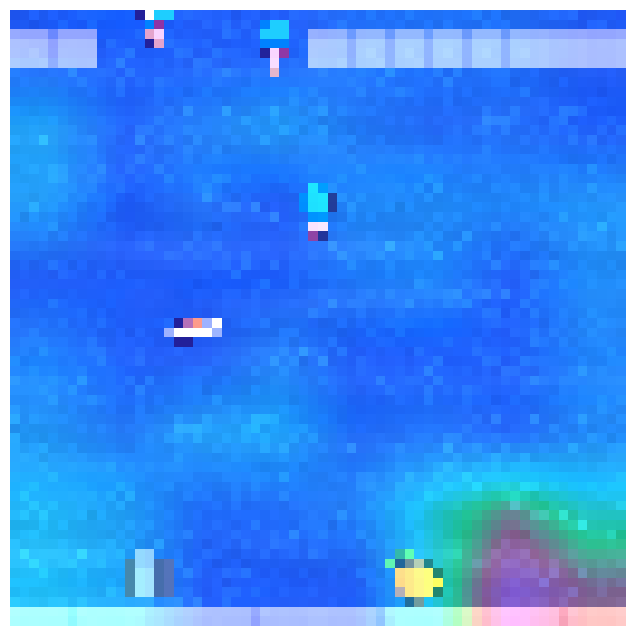

In [25]:
import cv2
heatmap = torch.mean(activations, dim=1).squeeze()
heatmap = np.maximum(heatmap.detach().cpu(), 0)
heatmap /= torch.max(heatmap)
heatmap = cv2.resize(np.float32(heatmap), (obs.shape[2], obs.shape[3]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW) / 255
superposed_img = obs_to_image(obs)/255 + heatmap*0.4
plt.figure(figsize=(8,8))
plt.imshow(np.clip(superposed_img, 0 , 1))
plt.axis('off')

In [26]:
def compute_grad_cam(state, hook, agent):

  obs = torch.FloatTensor(state).to('cuda')
  action = agent(obs).argmax(1).cpu().numpy()

  output = agent(obs)
  output_idx = output.argmax()
  output_max = output[0, output_idx]
  output_max.backward()

  gradients = hook.gradients
  activations = hook.features
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # we take the average gradient of every chanels
  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim=1).squeeze()
  heatmap = np.maximum(heatmap.detach().cpu(), 0)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(np.float32(heatmap), (obs.shape[2], obs.shape[3]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW) / 255
  superposed_img = obs_to_image(state)/255 + heatmap*0.4
  return np.clip(superposed_img, 0 , 1)

In [29]:
frames = []
grad_cam = []
obs = env.reset()
it = 0
while True:
    frames.append(obs)
    hook = HookFeatures(agent.features)
    grad_cam.append(compute_grad_cam(obs, hook, agent))

    obs = torch.FloatTensor(obs).to('cuda')
    action = agent(obs).argmax(1).cpu().numpy()
    obs, _, done ,_ = env.step(action)
    img = env.render()
    it += 1
    if done[0]:
        break
#env.close()
hook.close()


In [43]:
create_gif(grad_cam, "grad_cam.gif", duration = 65)

Output hidden; open in https://colab.research.google.com to view.

Grad-CAM is used to visualize the regions of an input image that are most influential in the model's decision. By computing gradients of the model's output with respect to feature maps, Grad-CAM shows important regions in the input image. It helps us understand and interpret the model's behavior. Grad-CAM is used to visualize the regions of an input image that are most influential in the model's decision. By computing gradients of the model's output with respect to feature maps, Grad-CAM shows important regions in the input image. It helps us understand and interpret the model's behavior.

As you can see from the gif, Grad-CAM illuminates the areas that will earn the agent points. The red areas are those that contribute most to increasing output and guide the agent through the environment. There are a few display bugs in some frames, but you can guess how the agent will react by looking at the coloured areas displayed.  

We also note that the gradients are very strong around the agent, and that shows why its vision is short-range, which explains why it does not anticipate its movements and always reacts at the last moment when it detects a fruit or a passage. We can observe that the bot is always considered as a region of strong influence in the model's decision. However, obstacles are not detected as important regions by the Grad-CAM method. Grad-CAM also indicates that some regions without fruit or obstacles are important in the model's decision, which is surprising.




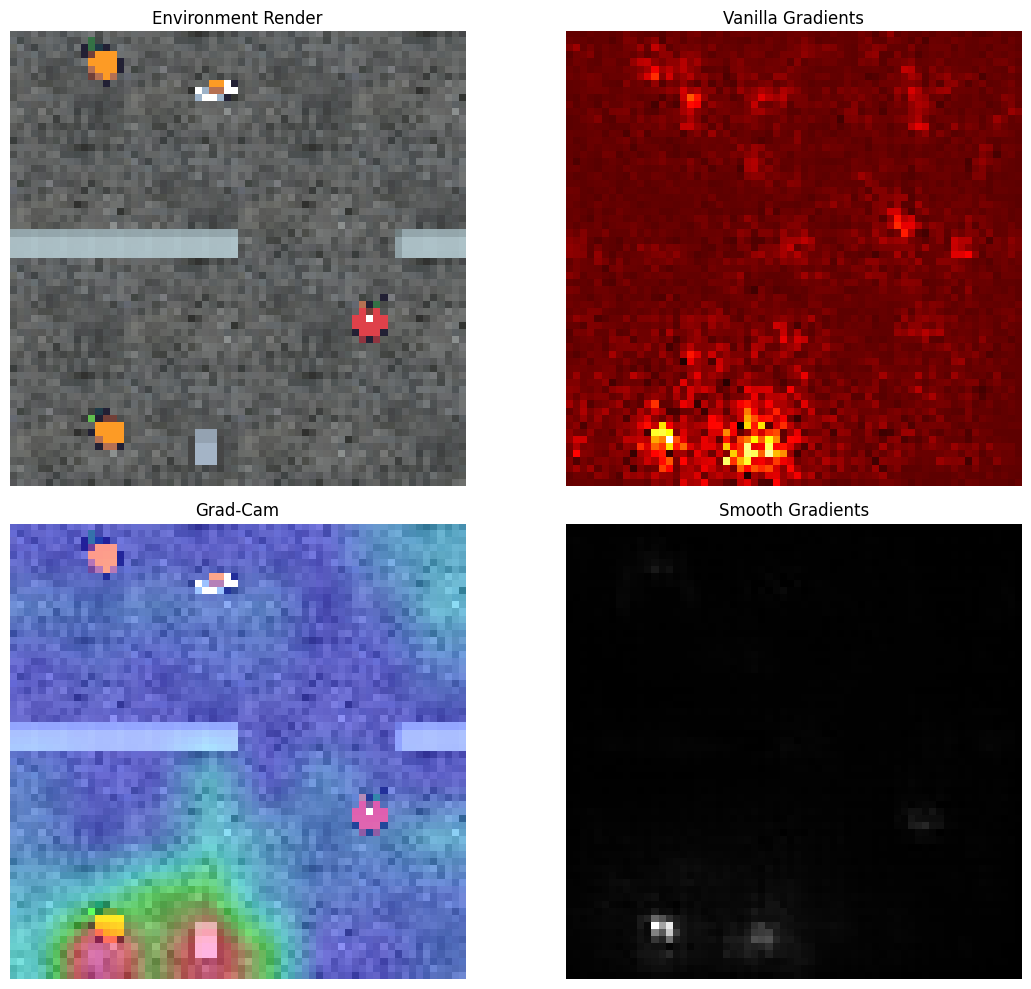

In [ ]:
def plot_env_and_all_gradients(env, agent, nb_action):
    state = env.reset()

    for i in range(nb_action):
      state = torch.FloatTensor(state).to('cuda')
      action = agent(state).argmax(1).cpu().numpy()
      state, _, done ,_ = env.step(action)

    # Compute gradients
    gradients = compute_vanilla_gradient(agent, state)
    smooth_gradients = compute_smooth_grad(agent, state)

    hook = HookFeatures(agent.features)
    cam_grad = compute_grad_cam(state, hook, agent)
    hook.close()

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plotting in the subplots
    axs[0, 0].imshow(env.render(mode='rgb_array'))
    axs[0, 0].set_title('Environment Render')
    axs[0, 0].axis('off')  # Turn off axis ticks and labels

    axs[0, 1].imshow(np.max(gradients[0], axis=0), cmap='hot')  # Assuming gradients is 2D, adjust as needed
    axs[0, 1].set_title('Vanilla Gradients')
    axs[0, 1].axis('off')  # Turn off axis ticks and labels

    axs[1, 0].imshow(cam_grad)  # Assuming gradients is 2D, adjust as needed
    axs[1, 0].set_title('Grad-Cam')
    axs[1, 0].axis('off')  # Turn off axis ticks and labels

    axs[1, 1].imshow(np.max(smooth_gradients[0], axis=0), cmap="gray")  # Assuming gradients is 2D, adjust as needed
    axs[1, 1].set_title('Smooth Gradients')
    axs[1, 1].axis('off')  # Turn off axis ticks and labels

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plot
    plt.show()


plot_env_and_all_gradients(env, agent, 52)

This plot shows our different methods.
* The environment render provides a raw depiction of the game state without highlighting specific areas of importance.

* Vanilla gradients show regions influencing the model's decision, but lack spatial localisation and can be noisy.

* Smooth gradients smooth out the noise but defining important pixels is still challenging.

* Grad-CAM puts a heatmap onto the environment picture, showing important areas clearly, we easily see where the model focuses to make decisions.

##Test de Captum

Captum is a model interpretability library developed by Facebook AI. It offers various attribution methods, such as Integrated Gradients, GradientShap, DeepLift, and others, which help in attributing model predictions to input features. We tried these methods for fun

In [35]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00


In [36]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import GuidedGradCam
from captum.attr import DeepLift
from captum.attr import visualization as viz

In [37]:
def plot_heatmap(attributions, img, tit = "Default method"):
  _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                              np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                              methods=["original_image", "heat_map"],
                              signs=['all', 'positive'],
                              cmap='hot',
                              show_colorbar=True, titles=["Environment Render", tit])

Plot side by side every visualisation for a specific action

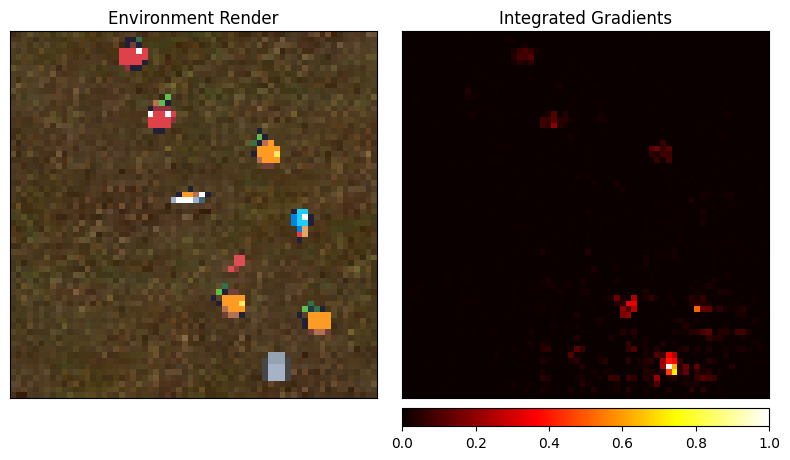

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


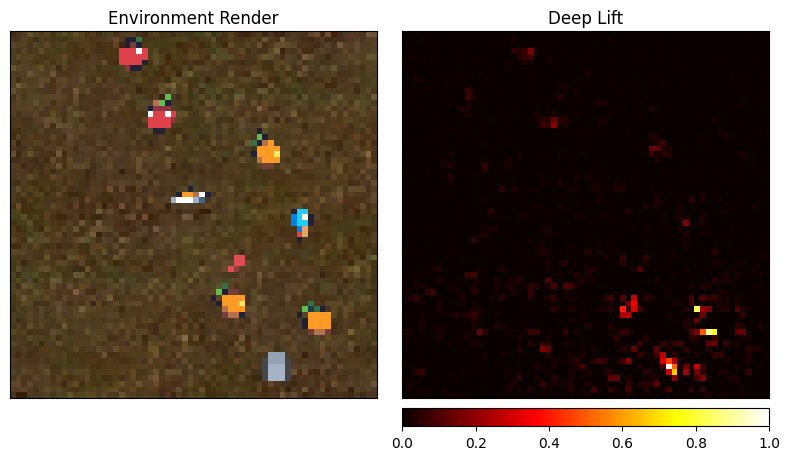

In [38]:
def plot_captum(env, agent, nb_action):

  state = env.reset()

  for i in range(nb_action):
    state = torch.FloatTensor(state).to('cuda')
    action = agent(state).argmax(1).cpu().numpy()
    state, _, done ,_ = env.step(action)

  obs = state
  obs = torch.FloatTensor(obs).to('cuda')
  integrated_gradients = IntegratedGradients(agent)
  attributions = integrated_gradients.attribute(obs, target=output_idx, n_steps=200, internal_batch_size=1)
  plot_heatmap(attributions, obs, tit = "Integrated Gradients")

  dl = DeepLift(agent)
  attributions = dl.attribute(obs, target=output_idx, baselines=obs * 0)
  plot_heatmap(attributions, obs, tit = "Deep Lift")

plot_captum(env, agent, 5)

Captum's methods allow us to better identify regions with strong gradients. Overall, we observe the same results as before, and therefore the same conclusions about the agent's movements.